#### **Model from Scratch**
---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import string
import random

import os
from PIL import Image
import cv2

import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

#### **Training Dataset import**
----

In [2]:
class Chars74kDataset(Dataset):
    def __init__(self, root_dir, gen_transforms=None, train_transforms=None, train=True):

        self.root_dir = root_dir
        self.gen_transforms = gen_transforms
        self.train_transforms = train_transforms
        self.train = train

        self.samples = []
        for cls in sorted(os.listdir(root_dir)):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith('.png'):
                    self.samples.append((os.path.join(cls_dir, fname), cls))

        self.classes = sorted({label for img, label in self.samples})
        self.cls2idx = {cls: idx + 1 for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, cls = self.samples[idx]
        img = Image.open(path).convert("L")

        if self.gen_transforms:
            img = self.gen_transforms(img)
        if self.train and self.train_transforms:
            img = self.train_transforms(img)

        label = self.cls2idx[cls]
        return img, label

In [3]:
gen_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x < 0.7).float())
])

train_augment = transforms.Compose([
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
])

#### **Séparation des données**

Pour garantir une évaluation fiable et éviter toute fuite d’information (data leakage) :

* **3 ensembles distincts** :

  * `train` (65 %) : apprentissage des paramètres du modèle.
  * `val` (15 %) : réglage des hyperparamètres et choix de la meilleure version du modèle.
  * `test` (20 %) : mesure finale de performance, à n’utiliser qu’une seule fois après la phase de validation.

In [5]:
full_dataset = Chars74kDataset(root_dir='C:/Users/G-PROGNOS-01/Desktop/Slomiany Baptiste/doc_lisibility/data/Chars74k/EnglishImg', gen_transforms=gen_transform,
                               train_transforms=None, train=False)
all_labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
temp_idx, test_idx = next(sss1.split(np.zeros(len(all_labels)), all_labels))

temp_labels = all_labels[temp_idx]
val_size = 0.15 / 0.8
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
train_subidx, val_subidx = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))

train_idx = temp_idx[train_subidx]
val_idx   = temp_idx[val_subidx]

In [6]:
train_dataset = Chars74kDataset(root_dir='C:/Users/G-PROGNOS-01/Desktop/Slomiany Baptiste/doc_lisibility/data/Chars74k/EnglishImg', gen_transforms=gen_transform,
                                train_transforms=train_augment, train=True)
train_ds = Subset(train_dataset, train_idx)

val_dataset = Chars74kDataset(root_dir='C:/Users/G-PROGNOS-01/Desktop/Slomiany Baptiste/doc_lisibility/data/Chars74k/EnglishImg', gen_transforms=gen_transform,
                              train_transforms=None, train=False)
val_ds = Subset(val_dataset, val_idx)

test_dataset = Chars74kDataset(root_dir='C:/Users/G-PROGNOS-01/Desktop/Slomiany Baptiste/doc_lisibility/data/Chars74k/EnglishImg', gen_transforms=gen_transform,
                               train_transforms=None, train=False)
test_ds = Subset(test_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)

#### **Visualisation**
---

In [7]:
characters = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
class_names = {i + 1: char for i, char in enumerate(characters)}

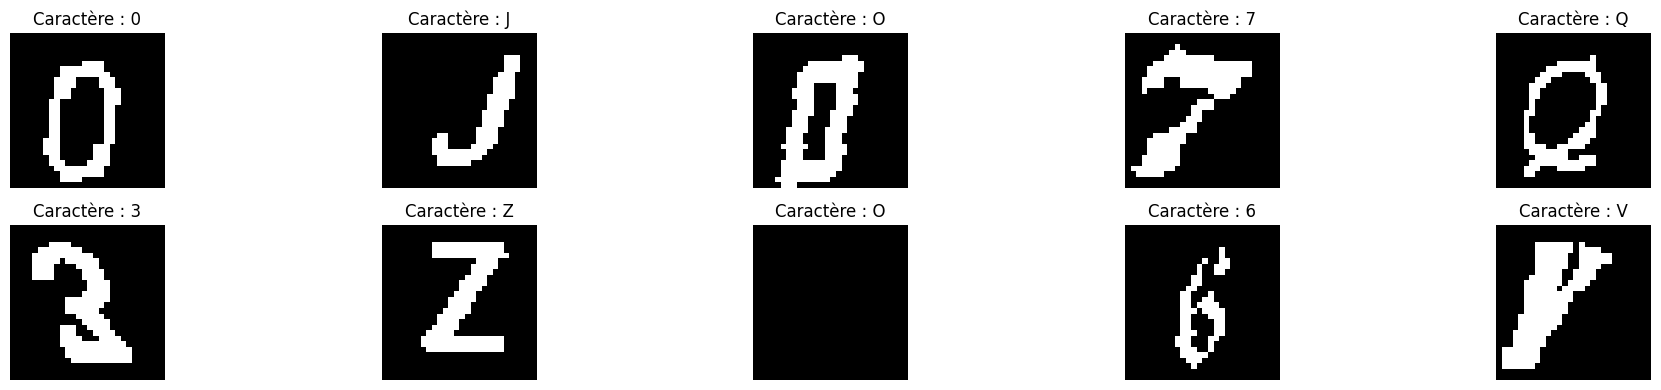

In [8]:
def show_random_chars(dataset, n_rows=2, n_cols=5, class_names=None):
    n = n_rows * n_cols
    indices = random.sample(range(len(dataset)), n)
    images, labels = zip(*[dataset[i] for i in indices])

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2*n_rows))

    for ax, img, label in zip(axes.flatten(), images, labels):
        img_np = img.squeeze().numpy()

        ax.imshow(img_np, cmap='gray')
        ax.axis('off')

        ax.set_title(f"Caractère : {class_names[label]}")
            
    plt.tight_layout()
    plt.show()

show_random_chars(train_dataset, class_names=class_names)

#### **Model definition and Training**
---

#### **Baseline**

In [13]:
class SimpleBaselineCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        x = self.features(x)
        if log_activations:
            activations['block1'] = x

        x = self.classifier(x)
        if log_activations:
            activations['logits'] = x
            return x, activations

        return x

In [14]:
### Train function
def train_model( model, train_loader, val_loader, num_epochs,
                 criterion, optimizer, writer ):

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            result = model(inputs)
            outputs = result[0] if isinstance(result, tuple) else result ## prise en compte retour activations
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                result = model(inputs)
                outputs = result[0] if isinstance(result, tuple) else result
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_corrects += (preds == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)

        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{num_epochs} | "
                  f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        writer.add_scalar("Loss/Train", epoch_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Acc/Train", epoch_acc, epoch)
        writer.add_scalar("Acc/Val", val_acc, epoch)

        for name, param in model.named_parameters():
            writer.add_histogram(name, param.cpu(), epoch)
            if param.grad is not None:
                writer.add_histogram(f"{name}_grad", param.grad.cpu(), epoch)

        images, _ = next(iter(val_loader))
        
        with torch.no_grad():
            result = model(images, log_activations=True)
            outputs, activations = result if isinstance(result, tuple) else (result, {})
        for layer, activation in activations.items():
            if activation.ndim == 4:
                for i in range(activation.size(1)):
                    writer.add_image(
                        f"Activations/{layer}/{i}",
                        activation[0, i].unsqueeze(0).cpu(),
                        epoch)

    writer.close()
    return model

In [15]:
### Parametrisation

cnn_model = SimpleBaselineCNN(63)
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/baseline_train0")
epochs = 5

cnn_model = train_model(cnn_model, train_loader, val_loader, epochs, criterion, optimizer, writer)
torch.save(cnn_model.state_dict(), "baseline_cnn0.pth")

Epoch 1/5 | Train Loss: 3.8652, Train Acc: 0.4109 | Val Loss: 0.9301, Val Acc: 0.7422
Epoch 2/5 | Train Loss: 1.3318, Train Acc: 0.6337 | Val Loss: 0.7948, Val Acc: 0.7783
Epoch 3/5 | Train Loss: 1.1681, Train Acc: 0.6726 | Val Loss: 0.7187, Val Acc: 0.7907
Epoch 4/5 | Train Loss: 1.0789, Train Acc: 0.6935 | Val Loss: 0.7124, Val Acc: 0.7919
Epoch 5/5 | Train Loss: 1.0174, Train Acc: 0.7067 | Val Loss: 0.6906, Val Acc: 0.7994


#### **VGGLikeNet**

In [ ]:
class VGGLikeNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        x = self.block1(x)
        if log_activations:
            activations['block1_out'] = x

        x = self.block2(x)
        if log_activations:
            activations['block2_out'] = x

        logits = self.classifier(x)
        if log_activations:
            activations['logits'] = logits
            return logits, activations
        
        return logits

In [17]:
### Parametrisation

cnn_model = VGGLikeNN(63)
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/vgglike_train0")
epochs = 5

cnn_model = train_model(cnn_model, train_loader, val_loader, epochs, criterion, optimizer, writer)
torch.save(cnn_model.state_dict(), "vgglikeNet0.pth")

Epoch 1/5 | Train Loss: 3.3958, Train Acc: 0.3287 | Val Loss: 0.9749, Val Acc: 0.7332
Epoch 2/5 | Train Loss: 1.4173, Train Acc: 0.6059 | Val Loss: 0.7376, Val Acc: 0.7815
Epoch 3/5 | Train Loss: 1.1626, Train Acc: 0.6660 | Val Loss: 0.6839, Val Acc: 0.7978
Epoch 4/5 | Train Loss: 1.0424, Train Acc: 0.6956 | Val Loss: 0.6258, Val Acc: 0.8063
Epoch 5/5 | Train Loss: 0.9722, Train Acc: 0.7104 | Val Loss: 0.5864, Val Acc: 0.8205


In [20]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.link = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1)
        )

    def forward(self, x):
        Y = self.block(x)
        X = self.link(x)

        return F.max_pool2d(F.relu(Y + X), 2, 2)

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.block1 = ResBlock(1, 16)
        self.block2 = ResBlock(16, 64)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        x = self.block1(x)
        if log_activations:
            activations['block1_out'] = x

        x = self.block2(x)
        if log_activations:
            activations['block2_out'] = x

        logits = self.classifier(x)
        if log_activations:
            activations['logits'] = logits
            return logits, activations
        
        return logits

In [21]:
### Parametrisation

cnn_model = ResNet(63)
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/resnetlike_train0")
epochs = 5

cnn_model = train_model(cnn_model, train_loader, val_loader, epochs, criterion, optimizer, writer)
torch.save(cnn_model.state_dict(), "resnetlikeNet0.pth")

Epoch 1/5 | Train Loss: 3.1577, Train Acc: 0.3299 | Val Loss: 1.0574, Val Acc: 0.7193
Epoch 2/5 | Train Loss: 1.5774, Train Acc: 0.5675 | Val Loss: 0.9310, Val Acc: 0.7413
Epoch 3/5 | Train Loss: 1.3598, Train Acc: 0.6214 | Val Loss: 0.8673, Val Acc: 0.7558
Epoch 4/5 | Train Loss: 1.2340, Train Acc: 0.6520 | Val Loss: 0.7640, Val Acc: 0.7800
Epoch 5/5 | Train Loss: 1.1660, Train Acc: 0.6657 | Val Loss: 0.7186, Val Acc: 0.7893


#### **ResNext**

In [22]:
class ResXBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True)
        )
        self.link = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, 1, 1)
        )

    def forward(self, x):
        Y = self.block(x)
        X = self.link(x)

        return F.max_pool2d(F.relu(torch.concat([X, Y], 1)), 2, 2)

class ResNeXt(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.block1 = ResXBlock(1, 16)
        self.block2 = ResXBlock(16, 64)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        x = self.block1(x)
        if log_activations:
            activations['block1_out'] = x

        x = self.block2(x)
        if log_activations:
            activations['block2_out'] = x

        logits = self.classifier(x)
        if log_activations:
            activations['logits'] = logits
            return logits, activations
        
        return logits

In [23]:
### Parametrisation

cnn_model = ResNeXt(63)
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/resneXtlike_train0")
epochs = 5

cnn_model = train_model(cnn_model, train_loader, val_loader, epochs, criterion, optimizer, writer)
torch.save(cnn_model.state_dict(), "resneXtlikeNet0.pth")

Epoch 1/5 | Train Loss: 2.6790, Train Acc: 0.4299 | Val Loss: 0.9889, Val Acc: 0.7298
Epoch 2/5 | Train Loss: 1.3757, Train Acc: 0.6210 | Val Loss: 0.8354, Val Acc: 0.7707
Epoch 3/5 | Train Loss: 1.1906, Train Acc: 0.6683 | Val Loss: 0.7694, Val Acc: 0.7883
Epoch 4/5 | Train Loss: 1.0919, Train Acc: 0.6907 | Val Loss: 0.7097, Val Acc: 0.8021
Epoch 5/5 | Train Loss: 1.0316, Train Acc: 0.7044 | Val Loss: 0.6736, Val Acc: 0.8057


#### **InceptionBased Network**

In [24]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, out_channels//4, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, out_channels//4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, out_channels//4, 5, 1, 2, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, out_channels//4, 7, 1, 3, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        Y1 = self.block1(x)
        Y2 = self.block2(x)
        Y3 = self.block3(x)
        Y4 = self.block4(x)

        return F.max_pool2d(F.relu(torch.concat([Y1, Y2, Y3, Y4], 1)), 2, 2)

class InceptionNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.block1 = InceptionBlock(1, 16)
        self.block2 = InceptionBlock(16, 64)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        x = self.block1(x)
        if log_activations:
            activations['block1_out'] = x

        x = self.block2(x)
        if log_activations:
            activations['block2_out'] = x

        logits = self.classifier(x)
        if log_activations:
            activations['logits'] = logits
            return logits, activations
        
        return logits

In [25]:
### Parametrisation

cnn_model = InceptionNet(63)
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/InceptionNetlike_train0")
epochs = 5

cnn_model = train_model(cnn_model, train_loader, val_loader, epochs, criterion, optimizer, writer)
torch.save(cnn_model.state_dict(), "InceptionNet0.pth")

Epoch 1/5 | Train Loss: 3.5310, Train Acc: 0.3934 | Val Loss: 0.9814, Val Acc: 0.7353
Epoch 2/5 | Train Loss: 1.2768, Train Acc: 0.6398 | Val Loss: 0.7537, Val Acc: 0.7798
Epoch 3/5 | Train Loss: 1.0932, Train Acc: 0.6860 | Val Loss: 0.7813, Val Acc: 0.7638
Epoch 4/5 | Train Loss: 1.0023, Train Acc: 0.7073 | Val Loss: 0.6858, Val Acc: 0.7951
Epoch 5/5 | Train Loss: 0.9505, Train Acc: 0.7168 | Val Loss: 0.6577, Val Acc: 0.7949
